In [1]:
%load_ext autoreload

In [1077]:
%autoreload
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit
from skimage import filters, measure, morphology, segmentation
from tqdm.auto import tqdm

sys.path.append("/scratch/gpfs/js5013/programs/cfilt/")
import cv2
from cfilt.utils import *

In [4]:
ds = CDS(
    [1, 4, 16, 1600],
    "jx",
    "../out/",
    crop=True,
    normalize=True,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [347]:
im1 = ds.images[4][10]
im4 = ds.images[4][10]
im16 = ds.images[16][10]
im1600 = ds.images[1600][10]

In [1053]:
im1c = np.copy(im1)
edges = ndimage.gaussian_laplace(im1c, sigma=2)
im1c = ndimage.gaussian_filter(im1c, sigma=0.5)
im1c = discretize_image(im1c, 35)

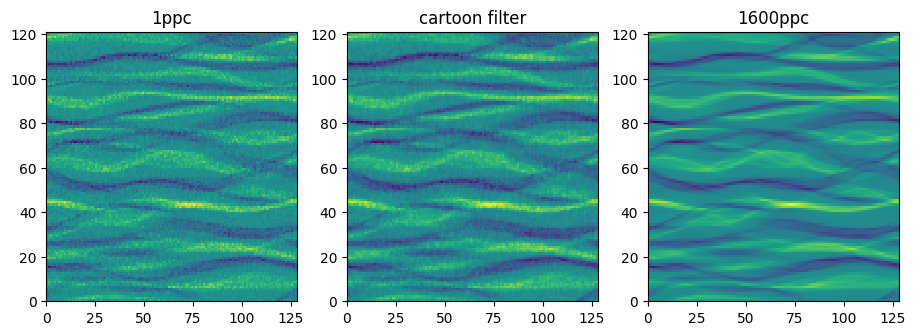

In [1054]:
fig, ax = qplot([im1, im1c, im1600])
labels = ["1ppc", "cartoon filter", "1600ppc"]
for i in range(3):
    ax[i].set_title(labels[i])

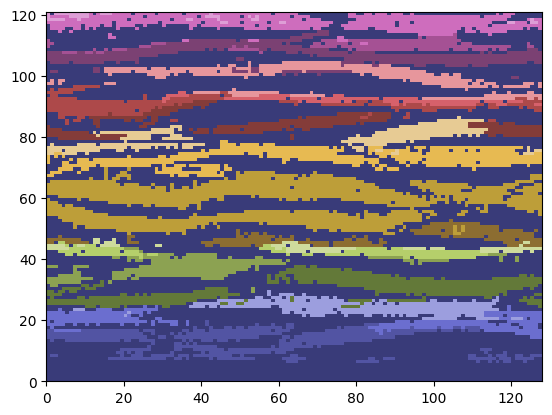

In [1085]:
imseg = morphology.remove_small_objects(
    measure.label(
        discretize_image(
            erode_image(ndimage.gaussian_filter(im1c, sigma=0.3)),
            7,
        ),
    ),
    min_size=2,
    connectivity=2,
)
plt.pcolormesh(imseg, cmap="tab20b")

In [1086]:
lbls, cts = np.unique(imseg, return_counts=True)
len(lbls)

328

In [1087]:
im1cc = np.zeros_like(im1)
buffer = np.copy(im1)
renorm = np.ones_like(im1)

for i, j in zip(lbls, cts):
    mask = imseg == i
    original = buffer[~mask]
    buffer[~mask] = 0
    if j == cts.max():
        sigma = 10
    else:
        sigma = 0.2
    renorm_smooth = ndimage.gaussian_filter(renorm, sigma=sigma)

    buffer_smooth = buffer.copy()
    for _ in range(1):
        buffer_smooth = ndimage.gaussian_filter(buffer_smooth, sigma=sigma)
        buffer_smooth = buffer_smooth / renorm_smooth
    im1cc[mask] = buffer_smooth[mask]
    buffer[~mask] = original

In [ ]:
qplot([im1, im1c, im1cc, im1600])

(<Figure size 1400x350 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

(<Figure size 800x350 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

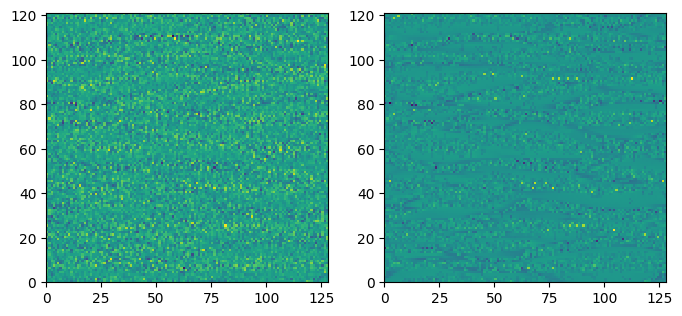

In [1040]:
qplot(
    [
        im1600 / im1600.std() - im1 / im1.std(),
        im1600 / im1600.std() - im1cc / im1cc.std(),
    ]
)

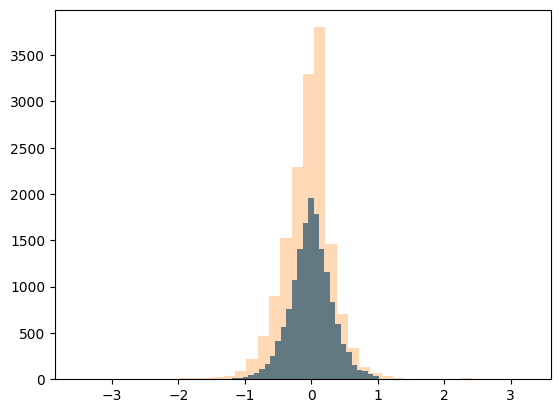

In [1042]:
plt.hist(np.ravel(im1600 / im1600.std() - im1 / im1.std()), bins=40)
plt.hist(np.ravel(im1600 / im1600.std() - im1cc / im1cc.std()), bins=40, alpha=0.3);